# Обучение моделей в Pytorch

In [33]:
import os
import random
from os.path import join as pjoin
from shutil import rmtree

import albumentations
import numpy as np
import torch
from accelerate import Accelerator
from albumentations.pytorch.transforms import ToTensorV2
from dataset import CustomDataset
from matplotlib import pyplot as plt
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from train import (
    CheckpointSaver,
    IoUMetric,
    MulticlassCrossEntropyLoss,
    MulticlassDiceLoss,
    load_checkpoint,
    train,
)
from unet import UNet, count_model_params

In [34]:
def seed_everything(seed: int = 314159, torch_deterministic: bool = False) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(torch_deterministic)


seed_everything(42, torch_deterministic=False)

## Аугментации

Трансформации/аугментации для исходных изображений и масок/таргетов.

Аугментации для задач компьютерного хрения: https://albumentations.ai/

In [35]:
IMAGE_SIZE = 256
transforms = albumentations.Compose(
    [
        albumentations.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        albumentations.AdvancedBlur(p=0.5),
        albumentations.GaussNoise(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.CLAHE(p=0.5),
        albumentations.RandomBrightnessContrast(p=0.5),
        albumentations.RandomGamma(p=0.5),
        albumentations.ColorJitter(p=0.5),
        ToTensorV2(),
    ]
)

## Dataset

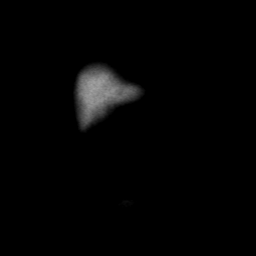

In [36]:
image_paths = ["C:/Segmentation/images/2007_000032.jpg"]
mask_paths = ["C:/Segmentation/masks/2007_000032.png"]
custom_dataset = CustomDataset(image_paths, mask_paths, transform=transforms)
len(custom_dataset)
image, target = custom_dataset[0]
Image.fromarray(image.numpy().astype(np.uint8).transpose(1, 2, 0))


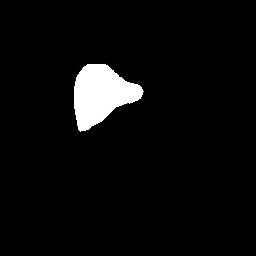

In [37]:
Image.fromarray(target.numpy().astype(np.uint8).transpose(1, 2, 0))

In [38]:
train_dataset = CustomVOCSegmentation(
    root="data",
    year="2012",
    image_set="train",
    download=False,
    transform=transforms,  # transform!
)

val_dataset = CustomVOCSegmentation(
    root="data",
    year="2012",
    image_set="val",
    download=False,
    transform=transforms,  # transform!
)

NameError: name 'CustomVOCSegmentation' is not defined

In [ ]:
image, target = train_dataset[0]
Image.fromarray(image.numpy().astype(np.uint8).transpose(1, 2, 0))

In [39]:
Image.fromarray(255 * target[15, :, :].numpy().astype(np.uint8))

IndexError: index 15 is out of bounds for dimension 0 with size 3

## UNet model

In [ ]:
model = UNet(in_channels=3, out_channels=21)
print(model)

In [40]:
count_model_params(model)

NameError: name 'model' is not defined

## Accelerator

In [ ]:
accelerator = Accelerator(cpu=False, mixed_precision="fp16")

## Обучаем модель

In [41]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
NUM_WORKERS = 2
EPOCH_NUM = 20
CHECKPOINTS_DIR = "checkpoints"
TENSORBOARD_DIR = "tensorboard"
RM_CHECKPOINTS_DIR = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [42]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)

model = UNet(in_channels=3, out_channels=21)

loss_fn = MulticlassCrossEntropyLoss(ignore_index=0)  # MulticlassDiceLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer, step_size=5, gamma=0.8
)
metric_fn = loss_fn

os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
checkpointer = CheckpointSaver(
    accelerator=accelerator,
    model=model,
    metric_name="DICE",
    save_dir=CHECKPOINTS_DIR,
    rm_save_dir=RM_CHECKPOINTS_DIR,
    max_history=5,
    should_minimize=True,
)

NameError: name 'train_dataset' is not defined

In [43]:
# !pip install tensorboard
# tensorboard_logger = None

os.makedirs(TENSORBOARD_DIR, exist_ok=True)
tensorboard_logger = torch.utils.tensorboard.SummaryWriter(log_dir=TENSORBOARD_DIR)

In [44]:
# акселерируем
model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)

NameError: name 'accelerator' is not defined

In [45]:
train(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_function=loss_fn,
    metric_function=metric_fn,
    lr_scheduler=lr_scheduler,
    accelerator=accelerator,
    epoch_num=EPOCH_NUM,
    checkpointer=checkpointer,
    tb_logger=tensorboard_logger,
    save_on_val=True,
)

NameError: name 'model' is not defined

## Загрузим и протестируем обученную модель

In [46]:
model = UNet(in_channels=3, out_channels=21)
model = load_checkpoint(
    model=model, load_path=pjoin(CHECKPOINTS_DIR, "model_checkpoint_best.pt")
)
model = model.to(DEVICE)
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints\\model_checkpoint_best.pt'

In [ ]:
sample_idx = 0
image, target = train_dataset[sample_idx]
target = torch.argmax(target, axis=0)
preds = torch.argmax(
    F.softmax(model(image.unsqueeze(0).to(DEVICE)), dim=1).squeeze(0), axis=0
)

fig, ax = plt.subplots(1, 3, figsize=(9, 18))
ax[0].imshow(image.numpy().transpose(1, 2, 0).astype(np.uint8))
ax[1].imshow(target.numpy())
ax[2].imshow(preds.cpu().numpy());